In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, Add, Activation
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, f1_score, classification_report, r2_score
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [2]:
# Definitions
img_width, img_height= 128, 128
batch_size = 32
No_epochs= 125

In [3]:
train_labels = {"ID": [], "class": [], "x_cent": [], "y_cent": [], "width": [], "height": [], "path": []}
test_labels = {"ID": [], "class": [], "x_cent": [], "y_cent": [], "width": [], "height": [], "path": []}

data_paths= ["Data/axial_t1wce_2_class/", "Data/coronal_t1wce_2_class/", "Data/sagittal_t1wce_2_class/"]

In [4]:
for data_path in data_paths:
    train_labels_path = os.path.join(data_path, "labels/train")
    test_labels_path = os.path.join(data_path, "labels/test")

    train_labels_filenames = os.listdir(train_labels_path)
    test_labels_filenames = os.listdir(test_labels_path)
    
    # Train labels
    for label_filename in train_labels_filenames:
        file_path = os.path.join(train_labels_path, label_filename)
        with open(file_path, "r") as train_label_file:
            content = train_label_file.read()
            parts= content.split()
            train_labels["ID"].append(label_filename[:-4])
            train_labels["class"].append(int(parts[0]))
            train_labels["x_cent"].append(float(parts[1]))
            train_labels["y_cent"].append(float(parts[2]))
            train_labels["width"].append(float(parts[3]))
            train_labels["height"].append(float(parts[4]))
            train_labels["path"].append(data_path + 'images/train/' + label_filename[:-4] + '.jpg')
    train_labels_df = pd.DataFrame(train_labels)
    
    # Test labels 
    for label_filename in test_labels_filenames:
        file_path = os.path.join(test_labels_path, label_filename)
        with open(file_path, "r") as test_label_file:
            content = test_label_file.read()
            parts= content.split()
            test_labels["ID"].append(label_filename[:-4])
            test_labels["class"].append(int(parts[0]))
            test_labels["x_cent"].append(float(parts[1]))
            test_labels["y_cent"].append(float(parts[2]))
            test_labels["width"].append(float(parts[3]))
            test_labels["height"].append(float(parts[4]))
            test_labels["path"].append(data_path + 'images/test/' + label_filename[:-4] + '.jpg')
    test_labels_df = pd.DataFrame(test_labels)

In [5]:
train_labels_df.head()

,ID,class,x_cent,y_cent,width,height,path
0,00095_170,0,0.428991,0.361502,0.144366,0.150235,Data/axial_t1wce_2_class/images/train/00095_17...
1,00095_176,0,0.443075,0.373826,0.142019,0.193662,Data/axial_t1wce_2_class/images/train/00095_17...
2,00095_188,0,0.424883,0.376761,0.215962,0.248826,Data/axial_t1wce_2_class/images/train/00095_18...
3,00095_200,0,0.426643,0.383216,0.250000,0.259390,Data/axial_t1wce_2_class/images/train/00095_20...
4,00095_212,0,0.437793,0.387324,0.237089,0.241784,Data/axial_t1wce_2_class/images/train/00095_21...


In [6]:
# Split the data into training and test sets
train_labels_df, dev_labels_df = train_test_split(train_labels_df, test_size=0.1, random_state=42)

In [7]:
Adding_part= test_labels_df.iloc[0:135]
test_labels_df= test_labels_df.iloc[135:]
train_labels_df= pd.concat([train_labels_df, Adding_part], axis= 0).reset_index()

print('Size of Train set: ', train_labels_df.shape)
print('Size of Dev set: ', dev_labels_df.shape)
print('Size of Test set: ', test_labels_df.shape)

Size of Train set:  (925, 8)
Size of Dev set:  (88, 7)
Size of Test set:  (88, 7)


In [8]:
# Checking data distribution
from collections import Counter
Counter(list(train_labels_df["class"]))

Counter({0: 474, 1: 451})

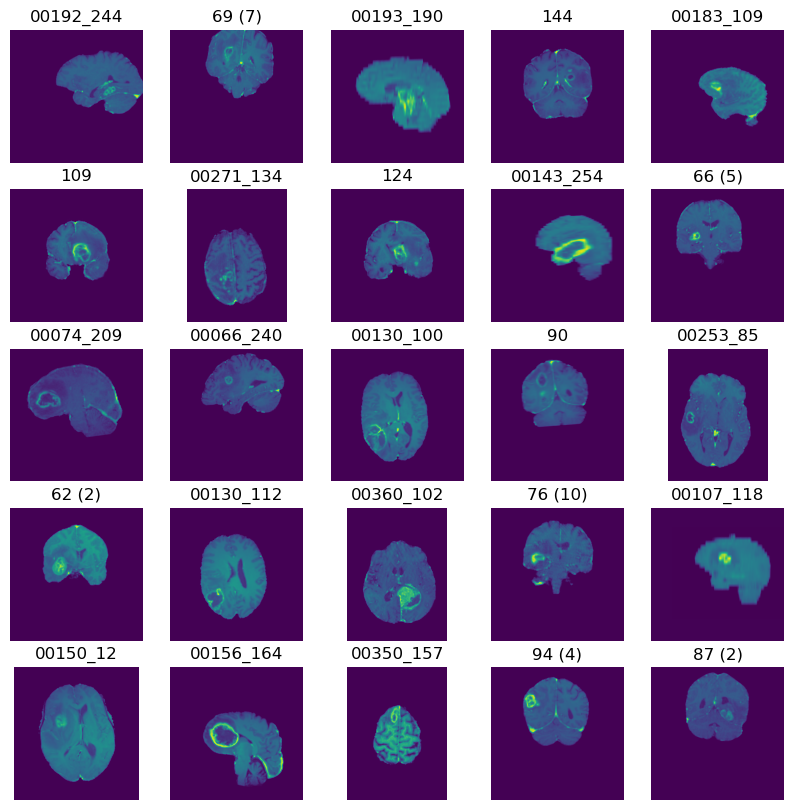

In [9]:
# Plot the images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    #path= data_path + 'images/train/' + train_labels_df['ID'].iloc[i] + '.jpg'
    image= Image.open(train_labels_df['path'].iloc[i])
    plt.imshow(image)
    plt.title(f"{train_labels_df['ID'].iloc[i]}")
    plt.axis('off')
plt.show()

In [10]:
# Function to load and preprocess images
def load_images(X, img_width, img_height):
    images = []
    for image_path in X:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_width, img_height))  # Resize to 128x128
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        #image = image / 255.0  # Normalize pixel values
        images.append(image)

    images = np.array(images)
    return images

# Load and preprocess images
X_train= load_images(train_labels_df['path'], img_width, img_height)

X_test = load_images(test_labels_df['path'], img_width, img_height)

X_dev = load_images(dev_labels_df['path'], img_width, img_height)

In [11]:
def show_image(X, labels=None, figsize=(4, 4), img_width= img_width, img_height= img_height):
    plt.figure(figsize=figsize)
    plt.imshow(X)
    if labels is not None:
        cx, cy, w, h = labels['x_cent'], labels['y_cent'], labels['width'], labels['height']
        cx, cy, w, h = cx*img_width, cy*img_height, w*img_width, h*img_height
        x = cx - w / 2
        y = cy - h / 2
        box = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(box)
        plt.text(x, y-2, f'Class: {labels["class"]}', color='y')

    plt.show()

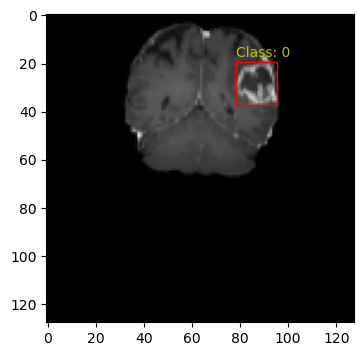

In [12]:
show_image(X= X_dev[80], labels=dev_labels_df.iloc[80])

In [13]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
    # Set device for TensorFlow operations
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
else:
    print('GPU is not available')

GPU is not available


In [16]:
# Define augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontally flip 50% of the images
    iaa.Affine(rotate=(-10, 10))  # rotate images by -10 to 10 degrees
])

In [17]:
# Function to apply augmentation to images and bounding boxes
def augment_images(images, bboxes):
    augmented_images = []
    augmented_bboxes = []
    for image, bbox in zip(images, bboxes):
        # Convert bounding box to imgaug format
        bbox_imgaug = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[0]+bbox[2], y2=bbox[1]+bbox[3])
        bbs = BoundingBoxesOnImage([bbox_imgaug], shape=image.shape)
        
        # Apply augmentation
        image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
        
        # Convert bounding box back to [x, y, w, h] format
        bbox_aug = [bbs_aug[0].x1, bbs_aug[0].y1, bbs_aug[0].x2 - bbs_aug[0].x1, bbs_aug[0].y2 - bbs_aug[0].y1]
        
        augmented_images.append(image_aug)
        augmented_bboxes.append(bbox_aug)
    
    return np.array(augmented_images), np.array(augmented_bboxes)



In [18]:
# Example usage
X_train_augmented, train_bboxes_augmented = augment_images(X_train, 
                                                           train_labels_df[['x_cent', 'y_cent', 'width', 'height']].values*img_width)

train_bboxes_augmented= train_bboxes_augmented/img_width

In [19]:
# Input layer
image_input = Input(shape=(img_width, img_height, 3))

# First convolutional block
x1= Conv2D(16, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))(image_input)
x1= BatchNormalization()(x1)
x1= Activation('relu')(x1)
x1= MaxPooling2D((2, 2))(x1)

# Second convolutional block
x2= Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))(x1)
x2= BatchNormalization()(x2)
x2= Activation('relu')(x2)

x3= Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))(x2)
x3= BatchNormalization()(x3)
x3= Activation('relu')(x3)

# skip connection
x3= Add()([x2, x3])
x3= MaxPooling2D((2, 2))(x3)

# Third convolutional block
x4= Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))(x3)
x4= BatchNormalization()(x4)
x4= Activation('relu')(x4)

x5= Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))(x4)
x5= BatchNormalization()(x5)
x5= Activation('relu')(x5)

# skip connection
x5= Add()([x4, x5])
x5= MaxPooling2D((2, 2))(x5)

# Fourth convolutional block
x6= Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))(x5)
x6= BatchNormalization()(x6)
x6= Activation('relu')(x6)
x6= MaxPooling2D((2, 2))(x6)

# Flatten and dense layers
x7= Flatten()(x6)

x8= Dense(256, activation='relu')(x7)
x8= Dropout(0.2)(x8)

# Output layers for class prediction (sigmoid for binary classification) and bounding box regression
class_output = Dense(1, activation='sigmoid', name='class_output')(x8)

bbox_output = Dense(4, name='bbox_output')(x8)  # 4 values for bounding box (x, y, w, h)

model = tf.keras.Model(inputs=image_input, outputs=[class_output, bbox_output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['batch_normalization[0][0

In [20]:
# Compile the model
model.compile(optimizer='adam', loss={'class_output': 'binary_crossentropy', 'bbox_output': 'mean_squared_error'}, 
             metrics={'class_output': 'accuracy', 'bbox_output': 'mse'})

# Update your model training with the augmented data
history = model.fit(X_train_augmented, {'class_output': train_labels_df['class'], 'bbox_output': train_bboxes_augmented}, 
                   validation_data=(X_dev, {'class_output': dev_labels_df['class'], 'bbox_output': dev_labels_df[['x_cent', 'y_cent', 'width', 'height']]}),
                    batch_size=batch_size, epochs=No_epochs)

Epoch 1/125
29/29 [==============================] - 21s 662ms/step - loss: 15.7904 - class_output_loss: 1.4034 - bbox_output_loss: 13.8833 - class_output_accuracy: 0.5038 - bbox_output_mse: 13.8833 - val_loss: 3.1306 - val_class_output_loss: 2.0628 - val_bbox_output_loss: 0.5607 - val_class_output_accuracy: 0.4886 - val_bbox_output_mse: 0.5607
Epoch 2/125
29/29 [==============================] - 23s 815ms/step - loss: 1.3034 - class_output_loss: 0.6951 - bbox_output_loss: 0.1014 - class_output_accuracy: 0.5135 - bbox_output_mse: 0.1014 - val_loss: 1.3060 - val_class_output_loss: 0.6905 - val_bbox_output_loss: 0.1093 - val_class_output_accuracy: 0.5455 - val_bbox_output_mse: 0.1093
Epoch 3/125
29/29 [==============================] - 23s 783ms/step - loss: 1.2759 - class_output_loss: 0.6875 - bbox_output_loss: 0.0833 - class_output_accuracy: 0.5405 - bbox_output_mse: 0.0833 - val_loss: 1.2765 - val_class_output_loss: 0.6821 - val_bbox_output_loss: 0.0906 - val_class_output_accuracy: 0.

Epoch 25/125
29/29 [==============================] - 22s 742ms/step - loss: 0.9090 - class_output_loss: 0.4669 - bbox_output_loss: 0.0337 - class_output_accuracy: 0.7514 - bbox_output_mse: 0.0337 - val_loss: 1.0283 - val_class_output_loss: 0.5950 - val_bbox_output_loss: 0.0271 - val_class_output_accuracy: 0.6705 - val_bbox_output_mse: 0.0271
Epoch 26/125
29/29 [==============================] - 22s 755ms/step - loss: 0.8821 - class_output_loss: 0.4449 - bbox_output_loss: 0.0332 - class_output_accuracy: 0.7557 - bbox_output_mse: 0.0332 - val_loss: 1.0933 - val_class_output_loss: 0.6637 - val_bbox_output_loss: 0.0278 - val_class_output_accuracy: 0.6705 - val_bbox_output_mse: 0.0278
Epoch 27/125
29/29 [==============================] - 23s 788ms/step - loss: 0.8682 - class_output_loss: 0.4350 - bbox_output_loss: 0.0334 - class_output_accuracy: 0.7470 - bbox_output_mse: 0.0334 - val_loss: 1.0368 - val_class_output_loss: 0.6192 - val_bbox_output_loss: 0.0200 - val_class_output_accuracy: 0.

Epoch 49/125
29/29 [==============================] - 22s 744ms/step - loss: 0.4964 - class_output_loss: 0.1516 - bbox_output_loss: 0.0209 - class_output_accuracy: 0.9027 - bbox_output_mse: 0.0209 - val_loss: 1.0298 - val_class_output_loss: 0.6937 - val_bbox_output_loss: 0.0144 - val_class_output_accuracy: 0.7386 - val_bbox_output_mse: 0.0144
Epoch 50/125
29/29 [==============================] - 23s 779ms/step - loss: 0.5124 - class_output_loss: 0.1722 - bbox_output_loss: 0.0204 - class_output_accuracy: 0.8865 - bbox_output_mse: 0.0204 - val_loss: 1.1456 - val_class_output_loss: 0.8128 - val_bbox_output_loss: 0.0153 - val_class_output_accuracy: 0.6818 - val_bbox_output_mse: 0.0153
Epoch 51/125
29/29 [==============================] - 22s 743ms/step - loss: 0.5114 - class_output_loss: 0.1753 - bbox_output_loss: 0.0205 - class_output_accuracy: 0.8811 - bbox_output_mse: 0.0205 - val_loss: 1.1250 - val_class_output_loss: 0.7969 - val_bbox_output_loss: 0.0147 - val_class_output_accuracy: 0.

Epoch 73/125
29/29 [==============================] - 22s 777ms/step - loss: 0.4444 - class_output_loss: 0.1716 - bbox_output_loss: 0.0156 - class_output_accuracy: 0.8811 - bbox_output_mse: 0.0156 - val_loss: 1.0174 - val_class_output_loss: 0.7492 - val_bbox_output_loss: 0.0127 - val_class_output_accuracy: 0.7614 - val_bbox_output_mse: 0.0127
Epoch 74/125
29/29 [==============================] - 22s 750ms/step - loss: 0.4291 - class_output_loss: 0.1604 - bbox_output_loss: 0.0149 - class_output_accuracy: 0.9038 - bbox_output_mse: 0.0149 - val_loss: 1.0741 - val_class_output_loss: 0.8098 - val_bbox_output_loss: 0.0122 - val_class_output_accuracy: 0.7386 - val_bbox_output_mse: 0.0122
Epoch 75/125
29/29 [==============================] - 22s 750ms/step - loss: 0.3992 - class_output_loss: 0.1328 - bbox_output_loss: 0.0161 - class_output_accuracy: 0.9124 - bbox_output_mse: 0.0161 - val_loss: 0.9232 - val_class_output_loss: 0.6622 - val_bbox_output_loss: 0.0128 - val_class_output_accuracy: 0.

Epoch 97/125
29/29 [==============================] - 22s 739ms/step - loss: 0.4025 - class_output_loss: 0.1737 - bbox_output_loss: 0.0137 - class_output_accuracy: 0.8832 - bbox_output_mse: 0.0137 - val_loss: 1.4904 - val_class_output_loss: 1.2654 - val_bbox_output_loss: 0.0114 - val_class_output_accuracy: 0.6477 - val_bbox_output_mse: 0.0114
Epoch 98/125
29/29 [==============================] - 22s 763ms/step - loss: 0.4043 - class_output_loss: 0.1776 - bbox_output_loss: 0.0137 - class_output_accuracy: 0.8822 - bbox_output_mse: 0.0137 - val_loss: 0.8646 - val_class_output_loss: 0.6406 - val_bbox_output_loss: 0.0118 - val_class_output_accuracy: 0.6477 - val_bbox_output_mse: 0.0118
Epoch 99/125
29/29 [==============================] - 23s 791ms/step - loss: 0.4199 - class_output_loss: 0.1943 - bbox_output_loss: 0.0138 - class_output_accuracy: 0.8897 - bbox_output_mse: 0.0138 - val_loss: 1.3488 - val_class_output_loss: 1.1262 - val_bbox_output_loss: 0.0117 - val_class_output_accuracy: 0.

Epoch 121/125
29/29 [==============================] - 23s 777ms/step - loss: 0.4034 - class_output_loss: 0.2061 - bbox_output_loss: 0.0134 - class_output_accuracy: 0.8897 - bbox_output_mse: 0.0134 - val_loss: 0.9724 - val_class_output_loss: 0.7772 - val_bbox_output_loss: 0.0110 - val_class_output_accuracy: 0.7159 - val_bbox_output_mse: 0.0110
Epoch 122/125
29/29 [==============================] - 21s 740ms/step - loss: 0.3892 - class_output_loss: 0.1917 - bbox_output_loss: 0.0132 - class_output_accuracy: 0.8822 - bbox_output_mse: 0.0132 - val_loss: 1.1566 - val_class_output_loss: 0.9614 - val_bbox_output_loss: 0.0110 - val_class_output_accuracy: 0.7273 - val_bbox_output_mse: 0.0110
Epoch 123/125
29/29 [==============================] - 23s 795ms/step - loss: 0.4077 - class_output_loss: 0.2107 - bbox_output_loss: 0.0133 - class_output_accuracy: 0.8681 - bbox_output_mse: 0.0133 - val_loss: 1.3533 - val_class_output_loss: 1.1579 - val_bbox_output_loss: 0.0111 - val_class_output_accuracy:

In [21]:
# Evaluate the model
loss, class_loss, bbox_loss, class_accuracy, bbox_mse= model.evaluate(X_test, {'class_output': test_labels_df['class'], 'bbox_output': test_labels_df[['x_cent', 'y_cent', 'width', 'height']]})
print(f"Test accuracy: {class_accuracy}")
print(f"Test MSE: {bbox_mse}")

3/3 [==============================] - 1s 167ms/step - loss: 3.5755 - class_output_loss: 3.3806 - bbox_output_loss: 0.0116 - class_output_accuracy: 0.5455 - bbox_output_mse: 0.0116
Test accuracy: 0.5454545617103577
Test MSE: 0.011580664664506912


In [22]:
# Make predictions
y_pred = model.predict(X_test, batch_size=batch_size)

y_pred_classes= y_pred[0]
y_pred_bbox= y_pred[1]

y_pred_classes2= [0 if y_class<0.5 else 1 for y_class in y_pred_classes ]

3/3 [==============================] - 1s 192ms/step


In [23]:
y_pred_df= pd.DataFrame(data= y_pred[1], columns= ['x_cent', 'y_cent', 'width', 'height'])
y_pred_df['class'] = y_pred[0]

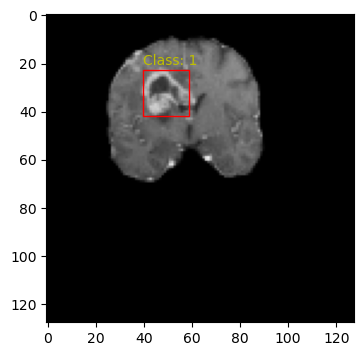

In [24]:
# A sample taget
show_image(X= X_test[0], labels=test_labels_df.iloc[0])

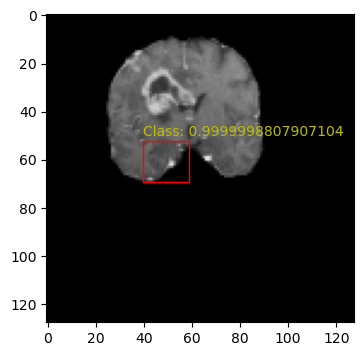

In [25]:
# The predicted taget
show_image(X= X_test[0], labels=y_pred_df.iloc[0])

In [26]:
# Calculate F1 score
f1 = f1_score(test_labels_df['class'], y_pred_classes2, average='micro')
print(f"F1 score: {f1}", '\n')

R2= r2_score(test_labels_df[['x_cent', 'y_cent', 'width', 'height']], y_pred_bbox)
print(f"R2 score: {R2}")

F1 score: 0.5454545454545454 

R2 score: -0.3756648354561018


In [27]:
# Calculate F1 score
Report = classification_report(test_labels_df['class'], y_pred_classes2)
print(Report)

              precision    recall  f1-score   support

           0       0.56      0.21      0.31        42
           1       0.54      0.85      0.66        46

    accuracy                           0.55        88
   macro avg       0.55      0.53      0.49        88
weighted avg       0.55      0.55      0.49        88



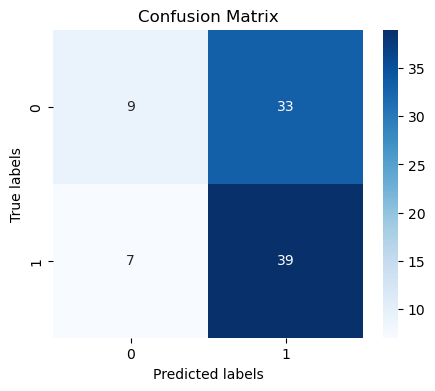

In [28]:
# Create confusion matrix
cm = confusion_matrix(test_labels_df['class'], y_pred_classes2)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
#plt.xticks(np.arange(1), labels, rotation=45)
#plt.yticks(np.arange(1), labels)
plt.show()

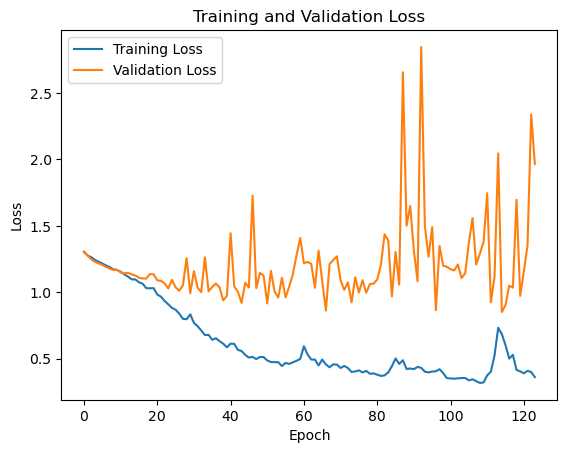

In [32]:
# Plot the loss values
plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

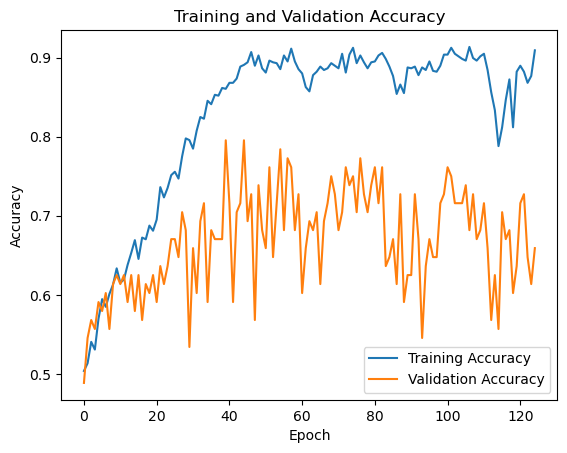

In [30]:
# Plot the accuracy values
plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [31]:
# Define the directory and filename
save_dir = 'Saved Models'
model_name = 'Brain_Tumor_Detection-Arch-1-3.h5'

# Save the model
model.save(os.path.join(save_dir, model_name))

C:\ProgramData\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
